In [1]:
include("../MathModule.jl")
using Main.MathModule
include("../GeometryModule.jl")
using Main.GeometryModule
include("../SourceModule.jl")
using Main.SourceModule
include("../MaterialModule.jl")
using Main.MaterialModule
include("../ObjectModule.jl")
using Main.ObjectModule
include("../DetectorModule.jl")
using Main.DetectorModule
include("../RayTrace.jl")
using .RayTrace

# include("../IllustrationModule.jl")
# using Main.IllustrationModule
# using PlotlyJS

# some constants
deg = π/180.0;
println("How many threads are available: ", Threads.nthreads())
using Plots

How many threads are available: 8


In [2]:
function sim_uconcentrator(h_cone::Float64, r_cone::Float64, θ_cone::Float64;num_bundle::Int64=10, size_bundle::Int64=1000, absorpcoef=10E-4)
    # absorpcoef in terms of 1/um
    lx = 2000.0
    ly = 2000.0
    tt = 500.0
    sources = Vector{Source}()
    objects = Vector{Object}()
    detectors = Vector{Detector}()
    setup = Setup(sources, objects, detectors)

    geo_box = make_box(lx, ly, tt-h_cone, [0.0, 0.0, (tt-h_cone)/2.0])
    geo_cone = make_cone(r_cone, r_cone+h_cone*tan(θ_cone), h_cone, [0.0, 0.0, tt-h_cone])
    diamond_vary = Dielectric(2.4, absorpcoef)
    rectbox = Object(
        geo_box, 
        diamond_vary
    )

    uconcent = Object(
        geo_cone, 
        diamond_vary
    )

    setup.objects = [rectbox, uconcent]

    nv_depth = 0.5
    center_ps = [0.0, 0.0, tt - nv_depth]
    psource = PointSource(
        Frame(center_ps, rm_eye),
        0.680, #[um]
        1.0, 
        isotropic_distribution()
    )
    setup.sources = [psource]

    # add the trajectory recorder if you want to see the rays
    # count_interval = size_bundle
    # det_tjrecord = TrajectoryRecorder(count_interval)

    wd = 3000.0
    na = 0.8
    nn = rectbox.material.n
    wd_eff = -wd+tt/nn*sqrt((1-na^2)/(1-(na/nn)^2))
    det_objective = Objective(
        Frame([0.0, 0.0, wd_eff], rm_eye),
        na,
        wd, 
        0.0
    )

    # setup.detectors = [det_tjrecord, det_objective]
    setup.detectors = [det_objective]

    threshold = 0.01
    max_depth = 100
    reset!(setup.detectors)
    Threads.@threads for _ in 1:num_bundle
        raybundle = Ray[]
        for source in setup.sources
            append!(raybundle, emit_rays(psource, size_bundle))
        end
        hitrecord_shortest = Vector{Union{Nothing, HitRecord}}(nothing, 2)
        tjroot = TrajectoryNode(raybundle[1], [])
        trajectory = Trajectory(tjroot)
        for ray in raybundle
            tjroot = TrajectoryNode(ray, [])
            trajectory.root = tjroot
            amp_terminate = threshold*ray.amplitude
            propagate_ray!(setup.objects, ray, hitrecord_shortest, tjroot, 0;
                        t_min=1e-6, t_max=1e6, amp_terminate=amp_terminate, depth_max=max_depth)
            for detector in setup.detectors
                detect!(detector, trajectory)
            end
            # println("Memory size of a trajectory: ", Base.summarysize(trajectory)/1024, " MB")
        end
    end

    fieldintensity = det_objective.collection/num_bundle/size_bundle
    # println("Field Intensity collected by Objective: $(round(fieldintensity * 100.0, digits=3))%")
    return fieldintensity
end

sim_uconcentrator (generic function with 1 method)

## Here we study the geomtry effect of the micro-concentrator

In [ ]:
num_raybundle = 20
size_raybundle = 1000
# reference: no uconcentrator
collection_nouconcent = sim_uconcentrator(0.0, 0.0, π/2.0;num_bundle=num_raybundle, size_bundle=size_raybundle)
alldata = Dict[];

h_cone = 10.0
r_cone = 10.0
θcone_list = collect(0.0:5.0:50.0)
collectin_list = zeros(length(θcone_list))
for (jj, θ_cone) in enumerate(θcone_list)
    collectin_list[jj] = sim_uconcentrator(h_cone, r_cone, θ_cone*deg;num_bundle=num_raybundle, size_bundle=size_raybundle)
end
dataset = Dict("h_cone"=>h_cone, "r_cone"=>r_cone, "θ_cone"=>θcone_list, "collection"=>collectin_list)
push!(alldata, dataset);

h_cone = 25.0
r_cone = 10.0
θcone_list = collect(0.0:5.0:50.0)
collectin_list = zeros(length(θcone_list))
for (jj, θ_cone) in enumerate(θcone_list)
    collectin_list[jj] = sim_uconcentrator(h_cone, r_cone, θ_cone*deg;num_bundle=num_raybundle, size_bundle=size_raybundle)
end
dataset = Dict("h_cone"=>h_cone, "r_cone"=>r_cone, "θ_cone"=>θcone_list, "collection"=>collectin_list)
push!(alldata, dataset);

h_cone = 25.0
r_cone = 5.0
θcone_list = collect(0.0:5.0:50.0)
collectin_list = zeros(length(θcone_list))
for (jj, θ_cone) in enumerate(θcone_list)
    collectin_list[jj] = sim_uconcentrator(h_cone, r_cone, θ_cone*deg;num_bundle=num_raybundle, size_bundle=size_raybundle)
end
dataset = Dict("h_cone"=>h_cone, "r_cone"=>r_cone, "θ_cone"=>θcone_list, "collection"=>collectin_list)
push!(alldata, dataset);

In [ ]:
# Plot the result
fig1 = plot(alldata[1]["θ_cone"], collection_nouconcent*100.0*ones(length(θcone_list)), label="Bare",  xlabel="Sidewall Angle [Deg]", ylabel="Collection [%]", title="Collection Efficiency of μ-Concentor", legend=:topleft)
for dataset in alldata
    plot!(fig1, dataset["θ_cone"], dataset["collection"]*100.0, label="h=$(dataset["h_cone"])μm, r=$(dataset["r_cone"])μm")
end
# Save the figure as a PNG file (you can also save in other formats like .jpg, .pdf, etc.)
savefig(fig1, "collection_efficiency_plot.png")

display(fig1)

In [ ]:
# Create secondary plot on the right y-axis
fig2 = plot(alldata[1]["θ_cone"], ones(length(θcone_list)), label="Bare",  xlabel="Sidewall Angle [Deg]", ylabel="Improvement", title="Collection Efficiency of μ-Concentor", legend=:topright)
for dataset in alldata
    plot!(fig2, dataset["θ_cone"], dataset["collection"]/collection_nouconcent, label="h=$(dataset["h_cone"])μm, r=$(dataset["r_cone"])μm")
end
# Save the figure as a PNG file (you can also save in other formats like .jpg, .pdf, etc.)
savefig(fig2, "collection_improvement_plot.png")

display(fig2)

## Here we study the absorption of the material

In [7]:
num_raybundle = 10
size_raybundle = 1000
h_cone = 0.0
r_cone = 0.0
θ_cone = π/2.0
α_list = collect(1.0:5.0:41.0)*1E-4# [1/um]
collect_α_bare_list = zeros(length(α_list))
for (jj, α) in enumerate(α_list)
    collect_α_bare_list[jj] = sim_uconcentrator(0.0, 0.0, π/2.0;num_bundle=num_raybundle, size_bundle=size_raybundle, absorpcoef=α)
end

h_cone = 25.0
r_cone = 5.0
θ_cone = 35.0
α_list = collect(1.0:5.0:41.0)*1E-4# [1/um]
collect_α_list = zeros(length(α_list))
for (jj, α) in enumerate(α_list)
    collect_α_list[jj] = sim_uconcentrator(h_cone, r_cone, θ_cone*deg;num_bundle=num_raybundle, size_bundle=size_raybundle, absorpcoef=α)
end
alldata_α = Dict[]
dataset_α = Dict("h_cone"=>h_cone, "r_cone"=>r_cone, "θ_cone"=>θ_cone, "α"=>α_list, "collection"=>collect_α_list)
push!(alldata_α, dataset_α)

1-element Vector{Dict}:
 Dict{String, Any}("r_cone" => 5.0, "collection" => [0.37491327318286116, 0.2230801431044685, 0.13389224863395044, 0.07949248009906973, 0.04829557231906647, 0.028279796943117406, 0.0173219106487769, 0.010435265337809857, 0.006120253203891833], "h_cone" => 25.0, "α" => [0.0001, 0.0006000000000000001, 0.0011, 0.0016, 0.0021000000000000003, 0.0026000000000000003, 0.0031000000000000003, 0.0036000000000000003, 0.0041], "θ_cone" => 35.0)

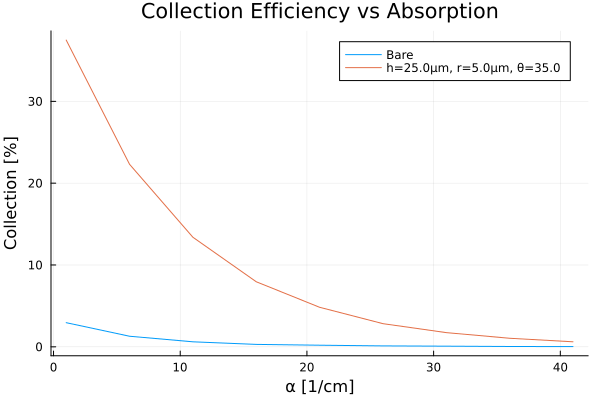

In [8]:
fig3 = plot(α_list*1e4, collect_α_bare_list*100.0, label="Bare",  xlabel="α [1/cm]", ylabel="Collection [%]", title="Collection Efficiency vs Absorption", legend=:topright)
for dataset in alldata_α
    plot!(dataset["α"]*1e4, dataset["collection"]*100.0, label="h=$(dataset["h_cone"])μm, r=$(dataset["r_cone"])μm, θ=$(dataset["θ_cone"]) ")
end
# Save the figure as a PNG file (you can also save in other formats like .jpg, .pdf, etc.)
savefig(fig3, "collection_vs_absorption_plot.png")
display(fig3)

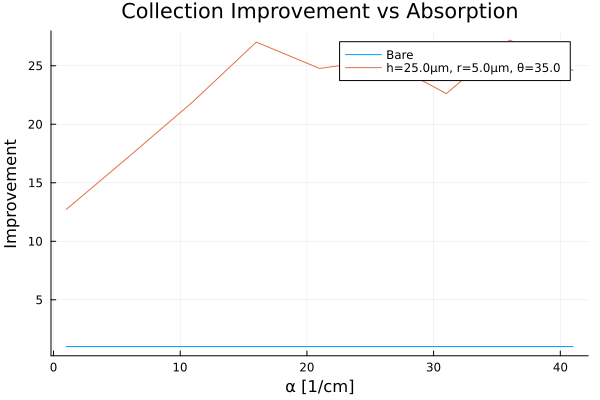

In [11]:
fig4 = plot(α_list*1e4, ones(length(α_list)), label="Bare",  xlabel="α [1/cm]", ylabel="Improvement", title="Collection Improvement vs Absorption", legend=:topright)
for dataset in alldata_α
    plot!(dataset["α"]*1e4, dataset["collection"]./collect_α_bare_list, label="h=$(dataset["h_cone"])μm, r=$(dataset["r_cone"])μm, θ=$(dataset["θ_cone"]) ")
end
# Save the figure as a PNG file (you can also save in other formats like .jpg, .pdf, etc.)
savefig(fig4, "improvement_vs_absorption_plot.png")
display(fig4)